# Sea ice draft from AUV, LiDAR and 3D photogrammetry
Adam Steer, adam.d.steer@gmail.com

Here I'm using AUV draft as 'truth' to look at some parameters for modelling sea ice thickness. My aims are:

- get descriptive stats from a patch of LiDAR-derived draft pretty close (within 1-sigma) of AUV draft
- visualise the correspondence (if any) of actual and modelled under-ice features

To do this I'm using the previously levelled and filtered LiDAR data from SIPEX2 IS6, which is also registered in the same coordinate system as the UAV draft. A second altimetry dataset ion the form of a point cloud from 3D photogrammetry is also employed, mainly as a proof-of-concept but also to see if there are gains in higher resolution.

So the first approach is to model ice thickness using a snow model from all possible drill holes in East Anarctica and adjust ice density until the mean ice draft from LiDAR and AUV are in agreement ( < 1-sigma). Next, determine if there are any improvements using a SIPEX-II specific snow model.

Finally, the 3D photogrammetric cloud is used in a similar way. The main questions for this method are:

- does it work? can we get reliable sea ice topography?
- are there any benefits to seeing very high resolution details?

Drill hole observations of ice thickness and surface topography (relative to sea level) are employed to validate (in a very constrained sense) all three surfaces. 

### Setting up

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import fsolve

%matplotlib inline

In [2]:
# this function is the snow depth model. Parameters come from Steer et al (2016):
#Estimating snow depth from altimery for East Antarctic pack ice

def compute_zs(tf, s_i, tf_uncert):
    """
    Take in the total freeboard (tf, float array), slope and intercept for an empirical model
    of snow depth from elevation (s_i, tuple) and the total freeboard uncertainty
    (tf_uncert, float array)

    Return a snow depth, with an associated uncertainty.
    zs, uncert = compute_zs(tf, ([slope, intercept]), tf_uncert)
    """
    
    zs = (s_i[0] * tf) + s_i[1]

    zs_uncert = s_i[0] * tf_uncert

    return zs, zs_uncert


In [3]:
# next define the model for estimating ice thickness from total freeboard, snow depth
# and some density parameters:

def compute_zi(tf, zs, d_ice, d_water, d_snow, sd_tf, sd_zs, sd_dsnow, \
               sd_dice, sd_dwater):
    """"
    sea ice thickness from elevation, and propagation of uncertainties
    after Kwok, 2010; kwok and cunningham, 2008
    equations:
    4: sea ice thickness from elevation
    6: taylor series expansion of variance/covariance propagation using
    partial derivatives
    8, 9 and 10: partial derivatives used in the taylor series
    """
    zi = (d_water / (d_water-d_ice)) * tf - ((d_water-d_snow) / \
         (d_water - d_ice)) * zs

    zi_uncert = sd_tf**2 * (d_water / (d_water - d_ice))**2 + \
           sd_zs**2 * ((d_snow - d_water) / (d_water - d_ice))**2 + \
           sd_dsnow**2 * (zs / (d_water - d_ice))**2 + \
           sd_dice**2 * (tf /  (d_water - d_ice))**2 + \
           sd_dwater**2 * (((-d_ice * tf) + ((d_ice-d_snow) * zs)) / \
           (d_water - d_ice)**2)**2

    return zi, zi_uncert


### getting data

In [4]:
## read in some pre-processed liDAR. This 2 million point bit already has ZI computed, but we ignore that for now
# and just get 3D point position, z uncertainty.
lidar = np.genfromtxt('/media/adam/data/is6_f11/python_zi/is6_f11_pass1_aa_nr2_522816_523019_c_zi.xyz', usecols = (0,1,2,3,4))

In [37]:
ship_inds = np.where((lidar[:,1] >= -110.3) &
              (lidar[:,1] <= 2.3) &
              (lidar[:,2] >= -80.95) &
              (lidar[:,2] <= -29.26))

In [38]:
l1 = np.zeros_like(lidar[:,0])
l1[ship_inds] = 1
lidar = lidar[np.where(l1 <1),:]

In [39]:
lidar = np.squeeze(lidar)

In [40]:
#get some AUV draft, pre trimmed
auv = np.genfromtxt('/media/adam/data/is6_f11/lidar_auv_analysis/auv_subset.txt')
auv_draft = auv[:,2]

In [41]:
# get a subset of LiDAR obs inside the AUV grid
subset = lidar[(lidar[:,1] >= -150) & (lidar[:,1] <= 130) & (lidar[:,2] >= -30) & (lidar[:,2] <= 275) ]
#get out some usefule bits of data
tf = subset[:,3] # total freeboard
tf_uncert = subset[:,4] # total freeboard uncertainty


## Part 1: Figuring out ice density to match UAV draft observations
First, plotting draft change with density using a whole-of-East-Antarctica snow model

In [42]:
#these parameters drive the sea ice thickness estimation model
d_snow = 326.31 #mean of all SIPEX-II obs
#d_snow = 305.67 #mean of all EA obs
sd_dsnow = 10
sd_dice = 10
d_water = 1028
sd_dwater = 1

In [43]:
# a quick function to make ice parameters from a range of density values
def build_dens(tf, zs, d_water, d_snow, tf_uncert, \
                    zs_uncert, sd_dsnow, sd_dice, sd_dwater,densities):
    d_table = []
    for d in densities:     
        zi, zi_uncert = compute_zi(tf, zs, d, d_water, d_snow, tf_uncert, \
                           zs_uncert, sd_dsnow, sd_dice, sd_dwater)
    
        d_table.append([d,np.mean(tf-(zs + zi)), np.median(tf-(zs + zi)), np.std(tf - (zs + zi)), np.mean(zi_uncert)])
    return np.array(d_table)

1


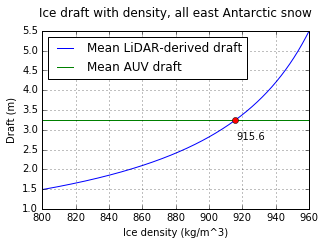

In [44]:
densities = np.arange(800,960,0.2)

#compute snow depth based on an empirical model
s_i = ([0.701, -0.0012]) #model from all EA drill holes
zs, zs_uncert = compute_zs(tf, s_i, tf_uncert)
d_table = []
d_table = build_dens(tf, zs, d_water, d_snow, tf_uncert, \
                    zs_uncert, sd_dsnow, sd_dice, sd_dwater, densities)
mean_draft = -d_table[:,1]

plt.figure(figsize=(12/2.51,8/2.51))

plt.plot(d_table[:,0], mean_draft, label='Mean LiDAR-derived draft')

auv_mean = np.zeros_like(densities, dtype='float32')
auv_mean[:] = np.nanmean(auv_draft)

plt.plot(d_table[:,0], auv_mean, label='Mean AUV draft')

idx = np.argwhere(np.isclose(auv_mean,mean_draft, atol=0.003)).reshape(-1)
plt.plot(densities[idx], mean_draft[idx], 'ro')

plt.text(densities[idx]+1, mean_draft[idx]-0.5, str(densities[idx][0]))
print(len(idx))
plt.ylabel('Draft (m)')
plt.xlabel('Ice density (kg/m^3)')
plt.grid()
plt.legend(loc=0)
plt.title('Ice draft with density, all east Antarctic snow', y=1.05)

plt.savefig('ch4_estimate_density_EA_snow.png', bbox_inches='tight')
plt.savefig('ch4_estimate_density_EA_snow.pdf', bbox_inches='tight')

In [45]:
zi, zi_uncert = compute_zi(tf, zs, densities[idx][0], d_water, d_snow, tf_uncert, \
                           zs_uncert, sd_dsnow, sd_dice, sd_dwater)

print('mean zi: {}, std zi: {}, mean zs: {}, mean draft: {}, std draft: {}'.
      format(np.mean(zi), np.std(zi), np.mean(zs), mean_draft[idx][0], d_table[idx,3][0]))

mean zi: 3.455223926957671, std zi: 1.7355475121562611, mean zs: 0.5055102525282407, mean draft: 3.2378950175340706, std draft: 1.6267507934624243


In [46]:
densities[idx]

array([ 915.6])

Using this snow model, we would need to approximate density as 915.6 kg/m^3 to make LiDAR derived draft realistic at a floe scale

### Let's change the snow model to SIPEX-II only

In [47]:
s_i_2 = ([0.64, 0.076]) #model from only SIPEX-II drill holes
zs_s2, zs_s2_uncert = compute_zs(tf, s_i_2, tf_uncert)

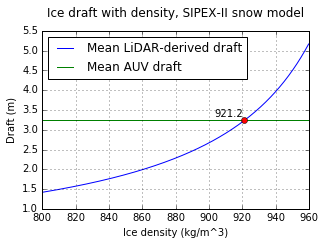

In [48]:
d_table = []
d_table = build_dens(tf, zs_s2, d_water, d_snow, tf_uncert, \
                    zs_s2_uncert, sd_dsnow, sd_dice, sd_dwater, densities)

mean_draft = -d_table[:,1]

plt.figure(figsize=(12/2.51,8/2.51))

plt.plot(densities, mean_draft, label='Mean LiDAR-derived draft')

plt.plot(densities, auv_mean, label='Mean AUV draft')

idx = np.argwhere(np.isclose(mean_draft, auv_mean, atol=0.003)).reshape(-1)
plt.plot(densities[idx], mean_draft[idx], 'ro')

plt.text(densities[idx]-18, mean_draft[idx] +0.1, str(densities[idx][0]))

plt.ylabel('Draft (m)')
plt.xlabel('Ice density (kg/m^3)')
plt.grid()
plt.legend(loc=0)
plt.title('Ice draft with density, SIPEX-II snow model', y=1.05)

plt.savefig('ch4_estimate_density_sipex2_snow.png', bbox_inches='tight')
plt.savefig('ch4_estimate_density_sipex2_snow.pdf', bbox_inches='tight')

In [49]:
densities[idx]

array([ 921.2])

In [15]:
zi, zi_uncert = compute_zi(tf, zs, densities[idx][0], d_water, d_snow, tf_uncert, \
                           zs_uncert, sd_dsnow, sd_dice, sd_dwater)
print('mean zi: {}, std zi: {}, mean zs: {}, mean draft: {}, std draft: {}'.
      format(np.mean(zi), np.std(zi), np.mean(zs), mean_draft[idx][0], d_table[idx,3][0]))

mean zi: 3.6368387592977927, std zi: 1.8260327115888537, mean zs: 0.5055719823120249, mean draft: 3.2351041629806407, std draft: 1.840866342812576


In [16]:
print('mean AUV draft: {}, std AUV draft: {}'.
      format(np.mean(auv_draft), np.std(auv_draft)))

mean AUV draft: 3.2371440703565115, std AUV draft: 1.9381890100880586


#### in situ mean snow depth was 0.27 m, ice thickness 1.731 m, from the transect line.


### Summary of tinkering with ice density

Using the all-EA snow model. we arrive at an ice density of 922.4 kg/m^3 for matching altimetry-derived draft and AUV draft on a floe scale. Although, snow depth is more than double in situ observations (with the caveat that likely only lower snow depths were sampled directly). Using the SIPEX-II snow model, ice density is 928.8 kg/m^2 and snow is 4 cm deeper.

These density values are extreme, given sampled values on SIPEX-II of around 800 - 870 kg/m^3. So what do we choose? Using a SIPEX-II snow model gives a better match to draft variability, but the all-EA model gives a closer match to snow depth. I think we can hold our noses, leap in and go for a better draft match - meaning the SIPEX-II snow model. Why is this? It's completely uncertain as to whether 0.27 m is a realistic snow depth for the site, based on a tiny (and potentially biased) sample.

## Part 2: Visualising ice draft from altimetry.

### loading some in situ observations for visualising, and later checking purposes

In [17]:
is6holes = np.genfromtxt('/media/adam/data/is6_f11/insitu/is6.csv', delimiter = ',')
is6zs = is6holes[:,4]
is6tf = is6holes[:,3] + is6holes[:,4]
is6fi = is6holes[:,3]
is6draft = is6holes[:,5]
nozero = np.where(is6draft == 0)
is6draft[nozero] = np.nan

### making a set of sea ice draft observations from LiDAR, based on density experiments above

In [18]:
# zs and zs uncertainty are already done, using the EA snow model
# so we just make thickness
d = 915.6

#this is a necessary hack. If zs > tf, then ice thickness will be negative. SO for those locations
# we set zs to 0. 
this = np.where(zs > tf)
zs[this] = 0

zi, zi_uncert = compute_zi(tf, zs, d, d_water, d_snow, tf_uncert, \
                           zs_uncert, sd_dsnow, sd_dice, sd_dwater)

draft = tf - (zi + zs)

In [19]:
min(draft)

-18.641816601918148

## Zooming in on the drill line, what do we get from LiDAR, AUV and drill observations?

In [20]:
auv_t = np.where((auv[:,0] > -0.2) & (auv[:,0] < 0.2) & (auv[:,1] >= 0) & (auv[:,1] <= 100))
lidar_t = np.where((subset[:,1] > -0.5) & (subset[:,1] < 0.5) & (subset[:,2] >= 0) & (subset[:,2] <= 100))

print('drillhole mean: {}, std: {}, N: {}'.format(np.nanmean(is6draft), np.nanstd(is6draft), len(is6draft[np.isfinite(is6draft)])))
print('auv mean: {}, std: {}, N: {}'.format(-np.nanmean(auv_draft[auv_t[0]]), np.nanstd(auv_draft[auv_t[0]]), len(~np.isnan(auv_draft[auv_t[0]]))))
print('lidar mean: {}, std: {}, N: {}'.format(np.nanmean(draft[lidar_t[0]]), np.nanstd(draft[lidar_t[0]]), len(~np.isnan(draft[lidar_t[0]]))))

drillhole mean: -1.63319587628866, std: 0.7246165660665278, N: 97
auv mean: -1.7128754716981132, std: 0.7155530264593197, N: 159
lidar mean: -1.5330584779579661, std: 0.8141849742219338, N: 65


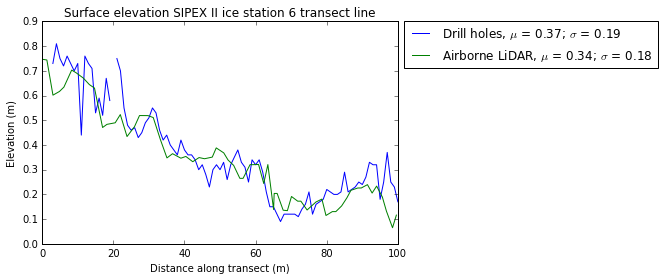

In [21]:
plt.figure(figsize=(16/2.51,10/2.51))
plt.plot(is6holes[:,1], is6tf,
         label='Drill holes, $\mu$ = {0:.2f}; $\sigma$ = {1:.2f}'.format(np.nanmean(is6tf), np.nanstd(is6tf)))
plt.plot(subset[lidar_t[0],2], subset[lidar_t[0],3],
         label='Airborne LiDAR, $\mu$ = {0:.2f}; $\sigma$ = {1:.2f}'.format(np.mean(subset[lidar_t[0],3]),
                                                                            np.std(subset[lidar_t[0],3])))
plt.legend(loc=2, bbox_to_anchor=(1,1.03))
plt.title('Surface elevation SIPEX II ice station 6 transect line')
plt.xlabel('Distance along transect (m)')
plt.ylabel('Elevation (m)')
plt.savefig('ch4_transect_surface_elev_is6.png', bbox_inches='tight')
plt.savefig('ch4_transect_surface_elev_is6.pdf', bbox_inches='tight')

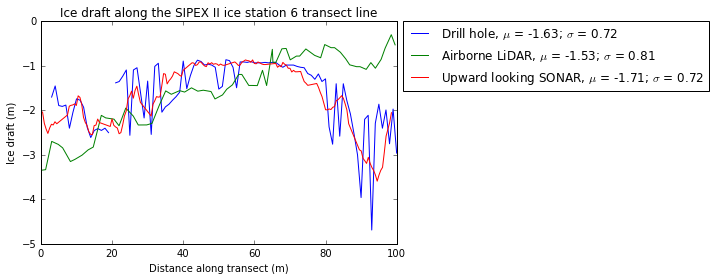

In [22]:
plt.figure(figsize=(16/2.51,10/2.51))

plt.plot(is6holes[:,1], is6draft,
         label=r'Drill hole, $\mu$ = {0:.2f}; $\sigma$ = {1:.2f}'.format(np.nanmean(is6draft), np.nanstd(is6draft)))
plt.plot(subset[lidar_t[0],2], draft[lidar_t[0]],
         label='Airborne LiDAR, $\mu$ = {0:.2f}; $\sigma$ = {1:.2f}'.format(np.mean(draft[lidar_t[0]]), np.std(draft[lidar_t[0]])))
plt.plot(auv[auv_t[0],1], -auv_draft[auv_t[0]], 
         label = 'Upward looking SONAR, $\mu$ = {0:.2f}; $\sigma$ = {1:.2f}'.format(np.mean(-auv_draft[auv_t[0]]), np.std(-auv_draft[auv_t[0]])))

plt.legend(loc=2, bbox_to_anchor=(1,1.03))
plt.title('Ice draft along the SIPEX II ice station 6 transect line')
plt.xlabel('Distance along transect (m)')
plt.ylabel('Ice draft (m)')
plt.savefig('ch4_transect_draft_is6.png', bbox_inches='tight')
plt.savefig('ch4_transect_draft_is6.pdf', bbox_inches='tight')

## Stack up LiDAR surface, draft, and AUV draft
...this is a figure in Chapter 4

In [23]:
#set up for 3d plots
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pylab as pylab

/usr/local/lib/python3.4/dist-packages/matplotlib/figure.py:1744: UserWarning: This figure includes Axes that are not compatible with tight_layout, so its results might be incorrect.
  warnings.warn("This figure includes Axes that are not "


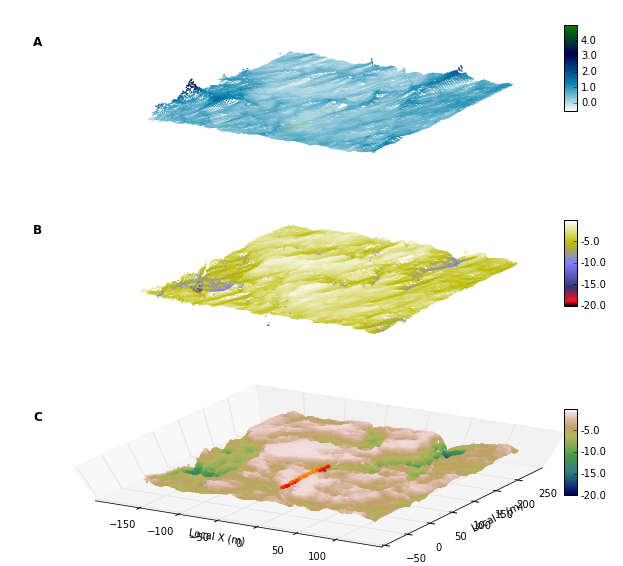

In [24]:
plt_az=300
plt_elev = 70.
plt_s = 2

cb_fmt = '%.1f'

fig = plt.figure()
fig.set_size_inches(22/2.51, 20/2.51)


ax0 = fig.add_subplot(311, projection='3d')
a0 = ax0.scatter(subset[:,1], subset[:,2], subset[:,3], c=np.ndarray.tolist(subset[:,3]),\
                cmap='ocean_r', lw=0, vmin = -0.5, vmax = 5, s=plt_s)
ax0.scatter(is6holes[:,0], is6holes[:,1], is6fi+is6zs, c=np.ndarray.tolist(is6fi+is6zs),\
                cmap='hot_r', lw=0, vmin = 0, vmax = 2, s=40)
ax0.view_init(elev=plt_elev, azim=plt_az)
ax0.set_xticks([]) 
ax0.set_yticks([]) 
ax0.set_axis_off() 
ax0.text2D(0.05, 0.8,'A', ha='center', va='center', transform=ax0.transAxes, fontsize=12, weight='bold')
cbaxes0 = fig.add_axes([0.9, 0.8, 0.02, 0.15]) 
cb0 = plt.colorbar(a0, cax=cbaxes0, ticks=np.arange(0,5,1), format=cb_fmt)

ax1 = fig.add_subplot(312, projection='3d')
a1 = ax1.scatter(subset[:,1], subset[:,2], draft, c=np.ndarray.tolist(draft),\
                cmap='gist_stern', lw=0, vmin = -20, vmax = 0, s = plt_s)
ax1.set_xticks([]) 
ax1.set_yticks([]) 
ax1.view_init(elev=plt_elev, azim=plt_az)
ax1.set_axis_off() 
ax1.text2D(0.05, 0.8,'B', ha='center', va='center', transform=ax1.transAxes, fontsize=12, weight='bold')
cbaxes1 = fig.add_axes([0.9, 0.46, 0.02, 0.15]) 
cb1 = plt.colorbar(a1, cax=cbaxes1, ticks=np.arange(-20, 0, 5), format=cb_fmt)

ax2 = fig.add_subplot(313, projection='3d')
a2 = ax2.scatter(auv[:,0], auv[:,1], -auv_draft, c=np.ndarray.tolist(-auv_draft),\
                cmap='gist_earth', lw=0, vmin = -20, vmax = 0, s = plt_s)
ax2.scatter(is6holes[:,0], is6holes[:,1], is6draft+3, c=np.ndarray.tolist(is6draft),\
                cmap='hot', lw=0, vmin = -5, vmax = 2, s=10)
ax2.view_init(elev=plt_elev, azim=plt_az)
ax2.w_zaxis.line.set_lw(0.)
ax2.set_zticks([])
ax2.text2D(0.05, 0.8,'C', ha='center', va='center', transform=ax2.transAxes, fontsize=12, weight='bold')
cbaxes2 = fig.add_axes([0.9, 0.13, 0.02, 0.15]) 
cb2 = plt.colorbar(a2, cax=cbaxes2, ticks=np.arange(-20, 0, 5), format=cb_fmt)

#ax2.set_axis_off() 
ax2.set_xticks(np.arange(np.min(auv[:,0]), np.max(auv[:,0]), 50))
ax2.set_yticks(np.arange(np.min(auv[:,1])-20, np.max(auv[:,1]), 50))
ax2.set_xlabel('Local X (m)', linespacing=4)
ax2.set_ylabel('Local Y (m)')
ax2.tick_params(axis='x', which='major', pad=15)
ax2.tick_params(axis='y', which='major', pad=15)
ax2.set_zticks([])
ax2.w_zaxis.line.set_lw(0.)

plt.tight_layout()

plt.savefig('is6_lidar_auv_draft_top.png', bbox_inches='tight')
plt.savefig('is6_lidar_auv_draft_top.pdf', bbox_inches='tight')

In this plot, panel A is LiDAR topography. Panel B is draft derived from LiDAR topography, and panel C is AUV draft. All plots cover 280 x 305 m, axes are not drawn because Python weirdness. Large features look OK, but snow topography introduces excessive roughness. In panel C there's a smooth patch just left of centre. It isn't present in Panel B because of snow ridge topography. So the **magnitude** of large features seems OK, but not really their shape or orientation. Small features in the under-ice realm are completely lost, and spurious snow dune reflections are added.

/usr/local/lib/python3.4/dist-packages/matplotlib/figure.py:1744: UserWarning: This figure includes Axes that are not compatible with tight_layout, so its results might be incorrect.
  warnings.warn("This figure includes Axes that are not "


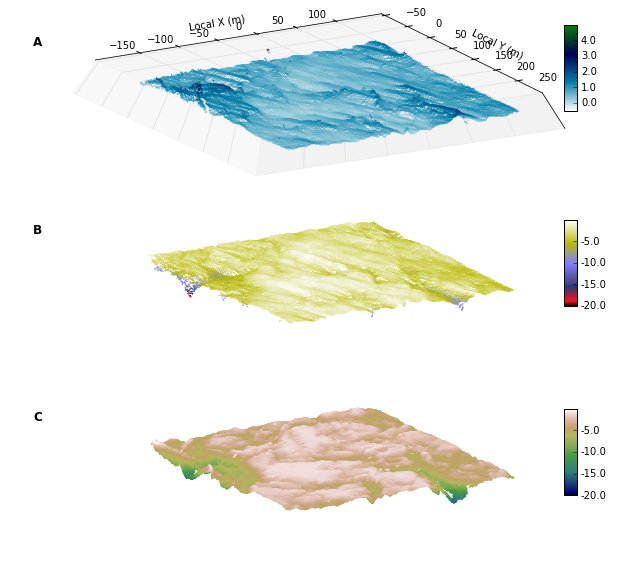

In [25]:
fig = plt.figure()
fig.set_size_inches(22/2.51, 20/2.51)


ax0 = fig.add_subplot(311, projection='3d')
a0 = ax0.scatter(subset[:,1], subset[:,2], subset[:,3], c=np.ndarray.tolist(subset[:,3]),\
                cmap='ocean_r', lw=0, vmin = -0.5, vmax = 5, s=plt_s)
ax0.scatter(is6holes[:,0], is6holes[:,1], is6fi+is6zs, c=np.ndarray.tolist(is6fi+is6zs),\
                cmap='hot_r', lw=0, vmin = 0, vmax = 2, s=10)
ax0.view_init(elev=-plt_elev, azim=plt_az)
ax0.text2D(0.05, 0.8,'A', ha='center', va='center', transform=ax0.transAxes, fontsize=12, weight='bold')
cbaxes0 = fig.add_axes([0.9, 0.8, 0.02, 0.15]) 
cb0 = plt.colorbar(a0, cax=cbaxes0, ticks=np.arange(0,5,1), format=cb_fmt)

#ax0.set_axis_off() 
ax0.set_xticks(np.arange(np.min(auv[:,0]), np.max(auv[:,0]), 50))
ax0.set_yticks(np.arange(np.min(auv[:,1])-20, np.max(auv[:,1]), 50))
ax0.set_xlabel('Local X (m)', linespacing=4)
ax0.set_ylabel('Local Y (m)')
ax0.tick_params(axis='x', which='major', pad=15)
ax0.tick_params(axis='y', which='major', pad=15)
ax0.set_zticks([])


ax1 = fig.add_subplot(312, projection='3d')
a1 = ax1.scatter(subset[:,1], subset[:,2], draft, c=np.ndarray.tolist(draft),\
                cmap='gist_stern', lw=0, vmin = -20, vmax = 0, s = plt_s)
ax1.set_xticks([]) 
ax1.set_yticks([]) 
ax1.view_init(elev=-plt_elev, azim=plt_az)
ax1.set_axis_off() 
ax1.text2D(0.05, 0.8,'B', ha='center', va='center', transform=ax1.transAxes, fontsize=12, weight='bold')
cbaxes1 = fig.add_axes([0.9, 0.46, 0.02, 0.15]) 
cb1 = plt.colorbar(a1, cax=cbaxes1, ticks=np.arange(-20, 0, 5), format=cb_fmt)

ax2 = fig.add_subplot(313, projection='3d')
a2 = ax2.scatter(auv[:,0], auv[:,1], -auv_draft, c=np.ndarray.tolist(-auv_draft),\
                cmap='gist_earth', lw=0, vmin = -20, vmax = 0, s = plt_s)
ax2.scatter(is6holes[:,0], is6holes[:,1], is6draft-5, c=np.ndarray.tolist(is6draft),\
                cmap='hot', lw=0, vmin = -10, vmax = 2, s=10)
ax2.view_init(elev=-plt_elev, azim=plt_az)
ax2.set_axis_off() 
ax2.w_zaxis.line.set_lw(0.)
ax2.set_zticks([])
ax2.text2D(0.05, 0.8,'C', ha='center', va='center', transform=ax2.transAxes, fontsize=12, weight='bold')
cbaxes2 = fig.add_axes([0.9, 0.13, 0.02, 0.15]) 
cb2 = plt.colorbar(a2, cax=cbaxes2, ticks=np.arange(-20, 0, 5), format=cb_fmt)


plt.tight_layout()

plt.savefig('is6_lidar_auv_draft_bottom.png', bbox_inches='tight')
plt.savefig('is6_lidar_auv_draft_bottom.pdf', bbox_inches='tight')

## Summary of section 2

We can see from stacking up the LiDAR surface, derived draft and AUV draft that there's good correspondence between really big features. The topography of snow dominates derived draft from altimetry, making smaller scale topography where there is none. Encouragingly, no special tricks were required to get LiDAR and transect line surface topography to agree. Under the ice, we see a couple of quite important things.

**Drill holes** are actually pretty good at getting ice thickness. The fact that the drill hole record is overly thin, then, is sampling bias rather than a method issue.

**LiDAR draft** is completely not getting under ice stuff at this scale, because the surface in this case bears no relationship to the underside. This is discussed heavily in ch2.

## Section 3: Adding a photogrammetry cloud

In [26]:
##import photo points, We try to kill Python!
photo = np.genfromtxt('/media/adam/data/is6_f11/photoscan/is6_f11_photoscan_aggr.pts', usecols = (0,1,2), skip_header=1)

#### Because of the opportunistic nature of these data, the survey area needs to be trimmed a lot closer to the 100 x 100 m patch of ice, so here we look at 150 x 150m. Not much, but enough to make something interesting. Also because the patch picked below still has 20 x 10^6 points!

In [27]:
#Take a subset of photo points
photo = photo[(photo[:,0] >= -25) & (photo[:,0] <= 125) & (photo[:,1] >= -25) & (photo[:,1] <= 125) ]

#index of AUV points to match                      
auv_ps = np.where((auv[:,0] >= -25) & (auv[:,0] <= 125) & (auv[:,1] >= -25) & (auv[:,1] <= 125))

#...and LIDAR to match                      
lidar_ps = np.where((subset[:,1] >= -25) & (subset[:,1] <= 125) & (subset[:,2] >= -25) & (subset[:,2] <= 125))

In [28]:
min(photo[:,2])

-0.78600000000000003

In [29]:
#therange = np.arange(0,len(photo[:,2]), 20)
#photo_s = photo[therange,:]

tf_p = photo[:,2]

#this = np.where(tf_p < 0)
#tf_p[this] = 0

sd_tfp = 0.1 #

#picking out some points along a transect line
photo_t = np.where((photo[:,0] > -0.1) & (photo[:,0] < 0.1) & (photo[:,1] >= 0) & (photo[:,1] <= 100))


#the points here are totally unorganised, so we need to sort by Y..
photo_pyz = photo[photo_t[0],1:3]
#photo_pz = photo_pts[photo_t[0],2]

photo_pyz = photo_pyz[photo_pyz[:,0].argsort()]

In [30]:
np.mean(subset[lidar_t[0],3])-np.mean(photo_pyz[:,1])

0.53772209409086591

In [31]:
np.mean(subset[lidar_ps,3])-np.mean(photo[:,2])

0.61434466389147857

### Plotting the transect
Here we repeat the transect line plots, with the photogrammetry-derived surface integrated.

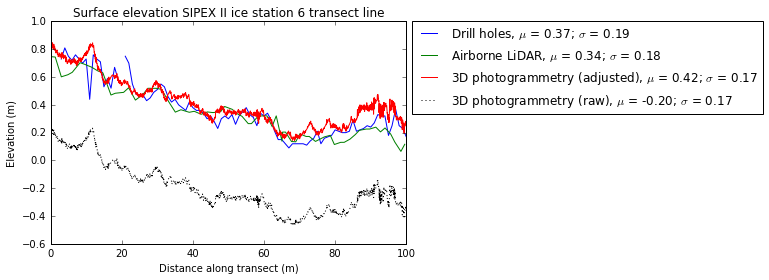

In [32]:
plt.figure(figsize=(16/2.51,10/2.51))

plt.plot(is6holes[:,1], is6tf,
         label='Drill holes, $\mu$ = {0:.2f}; $\sigma$ = {1:.2f}'.format(np.nanmean(is6tf), np.nanstd(is6tf)))
plt.plot(subset[lidar_t[0],2], subset[lidar_t[0],3],
         label='Airborne LiDAR, $\mu$ = {0:.2f}; $\sigma$ = {1:.2f}'.format(np.mean(subset[lidar_t[0],3]), np.std(subset[lidar_t[0],3])))
plt.plot(photo_pyz[:,0], photo_pyz[:,1]+0.614,
         label='3D photogrammetry (adjusted), $\mu$ = {0:.2f}; $\sigma$ = {1:.2f}'.format(np.mean(photo_pyz[:,1]+0.614), np.std(photo_pyz[:,1]+0.6)))
plt.plot(photo_pyz[:,0], photo_pyz[:,1], ':k',
         label='3D photogrammetry (raw), $\mu$ = {0:.2f}; $\sigma$ = {1:.2f}'.format(np.mean(photo_pyz[:,1]),
                                                                               np.std(photo_pyz[:,1])))

plt.legend(loc=2, bbox_to_anchor=(1,1.03))
plt.title('Surface elevation SIPEX II ice station 6 transect line')
plt.xlabel('Distance along transect (m)')
plt.ylabel('Elevation (m)')
plt.savefig('ch4_transect_surface_elev_is6.png', bbox_inches='tight')
plt.savefig('ch4_transect_surface_elev_is6.pdf', bbox_inches='tight')

In [33]:
#snow
zs_p, zsp_uncert = compute_zs(tf_p+0.614, s_i, sd_tfp)

#this = np.where(zs_p > tf_p)
#zs_p[this] = 0

#...and ice thickness!
zi_ps, zips_uncert = compute_zi(tf_p+0.614, zs_p, d, d_water, d_snow, sd_tfp,
                           zsp_uncert, sd_dsnow, sd_dice, sd_dwater)

# note that snow models and density were not re-defined!
draft_ps =  tf_p+0.614 - (zi_ps + zs_p)   

photo_yd = np.column_stack((photo[photo_t[0],1], draft_ps[photo_t[0]]))
photo_yd = photo_yd[photo_yd[:,0].argsort()]

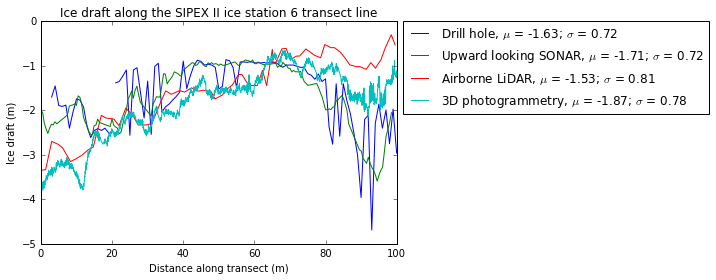

In [34]:
plt.figure(figsize=(16/2.51,10/2.51))

plt.plot(is6holes[:,1], is6draft,
         label=r'Drill hole, $\mu$ = {0:.2f}; $\sigma$ = {1:.2f}'.format(np.nanmean(is6draft), np.nanstd(is6draft)))
plt.plot(auv[auv_t[0],1], -auv_draft[auv_t[0]], 
         label = 'Upward looking SONAR, $\mu$ = {0:.2f}; $\sigma$ = {1:.2f}'.format(np.mean(-auv_draft[auv_t[0]]), np.std(-auv_draft[auv_t[0]])))
plt.plot(subset[lidar_t[0],2], draft[lidar_t[0]],
         label='Airborne LiDAR, $\mu$ = {0:.2f}; $\sigma$ = {1:.2f}'.format(np.mean(draft[lidar_t[0]]), np.std(draft[lidar_t[0]])))
plt.plot(photo_yd[:,0], photo_yd[:,1],
         label='3D photogrammetry, $\mu$ = {0:.2f}; $\sigma$ = {1:.2f}'.format(np.mean(photo_yd[:,1]), np.std(photo_yd[:,1])))
plt.legend(loc=2, bbox_to_anchor=(1,1.03))
plt.title('Ice draft along the SIPEX II ice station 6 transect line')
plt.xlabel('Distance along transect (m)')
plt.ylabel('Ice draft (m)')
plt.savefig('ch4_transect_draft_is6.png', bbox_inches='tight')
plt.savefig('ch4_transect_draft_is6.pdf', bbox_inches='tight')

### ...and some surface plots.

NameError: name 'photo_s' is not defined

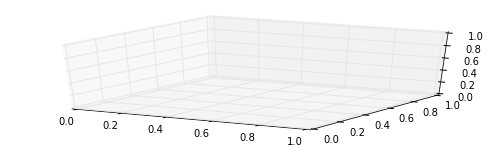

In [35]:
plt_az=300
plt_elev = 70.
plt_s = 2

#pylab.rcParams['figure.figsize'] = 18,20
cb_fmt = '%.1f'

#is6_draft = is6fi-is6holes[:,2]

fig = plt.figure()
fig.set_size_inches(22/2.51, 20/2.51)

ax0 = fig.add_subplot(311, projection='3d')

a0 = ax0.scatter(photo_s[:,0], photo_s[:,1], photo_s[:,2], c=np.ndarray.tolist(photo_s[:,2]),\
                cmap='ocean_r', lw=0, vmin = -0.5, vmax = 5, s = plt_s)
ax0.view_init(elev=plt_elev, azim=plt_az)
ax0.set_axis_off() 
ax0.text2D(0.05, 0.8,'A', ha='center', va='center', transform=ax0.transAxes, fontsize=12, weight='bold')
cbaxes0 = fig.add_axes([0.85, 0.78, 0.02, 0.15]) 
cb0 = plt.colorbar(a0, cax=cbaxes0, ticks=np.arange(0,5,1), format=cb_fmt)


ax1 = fig.add_subplot(312, projection='3d')

a1 = ax1.scatter(photo_s[:,0], photo_s[:,1], draft_ps, c=np.ndarray.tolist(draft_ps),\
                cmap='gist_stern', lw=0, vmin = -20, vmax = 0, s = plt_s)
ax1.set_xticks([]) 
ax1.set_yticks([]) 
ax1.view_init(elev=plt_elev, azim=plt_az)
ax1.set_axis_off() 
ax1.text2D(0.05, 0.8,'B', ha='center', va='center', transform=ax1.transAxes, fontsize=12, weight='bold')
cbaxes1 = fig.add_axes([0.85, 0.46, 0.02, 0.15]) 
cb1 = plt.colorbar(a1, cax=cbaxes1, ticks=np.arange(-20,0,5), format=cb_fmt)

ax2 = fig.add_subplot(313, projection='3d')
a2 = ax2.scatter(auv_s[:,0], auv_s[:,1], -auv_s[:,2], c=np.ndarray.tolist(-auv_s[:,2]),\
                cmap='gist_earth', lw=0, vmin = -20, vmax = 0, s = plt_s)
ax2.scatter(is6holes[:,0], is6holes[:,1], is6draft+3, c=np.ndarray.tolist(is6fi-is6holes[:,2]),\
                cmap='hot', lw=0, vmin = -5, vmax = 2, s=10)
ax2.view_init(elev=plt_elev, azim=plt_az)

#ax2.set_axis_off() 
ax2.set_xticks(np.arange(np.min(photo_s[:,0])-25, np.max(photo_s[:,0])+25, 25))
ax2.set_yticks(np.arange(np.min(photo_s[:,1])-25, np.max(photo_s[:,1])+25, 25))
ax2.set_xlabel('Local X (m)', linespacing=4)
ax2.set_ylabel('Local Y (m)')
ax2.tick_params(axis='x', which='major', pad=15)
ax2.tick_params(axis='y', which='major', pad=15)
ax2.set_zticks([])
ax2.w_zaxis.line.set_lw(0.)

ax2.text2D(0.05, 0.8,'C', ha='center', va='center', transform=ax2.transAxes, fontsize=12, weight='bold')
cbaxes2 = fig.add_axes([0.85, 0.15, 0.02, 0.15]) 
cb2 = plt.colorbar(a2, cax=cbaxes2, ticks=np.arange(-20,0,5), format=cb_fmt)
plt.savefig('is6_photo_auv_draft_top.png', bbox_inches='tight')
plt.savefig('is6_photo_auv_draft_top.pdf', bbox_inches='tight')

### These plots are a view from above.
If anything, increasing resolution has increased the small-scale roughness in draft estimates based on snow dunes (panel B). Also the features are very linear - so any ice/ocean interaction derived from these data would be skewed **if** any direction vectors are implied.

In [ ]:
np.arange(np.min(photo_s[:,0]), np.max(photo_s[:,0]), 25)

In [ ]:
plt_az=300
plt_elev = -70.
plt_s = 2

#pylab.rcParams['figure.figsize'] = 18,20
cb_fmt = '%.1f'

#is6_draft = is6fi-is6holes[:,2]

fig = plt.figure()
fig.set_size_inches(22/2.51, 20/2.51)

ax0 = fig.add_subplot(311, projection='3d')

a0 = ax0.scatter(photo_s[:,0], photo_s[:,1], photo_s[:,2], c=np.ndarray.tolist(photo_s[:,2]),\
                cmap='ocean_r', lw=0, vmin = -0.5, vmax = 5, s = plt_s)
ax0.view_init(elev=plt_elev, azim=plt_az)
ax0.text2D(0.05, 0.8,'A', ha='center', va='center', transform=ax0.transAxes, fontsize=12, weight='bold')
cbaxes0 = fig.add_axes([0.85, 0.78, 0.02, 0.15]) 
cb0 = plt.colorbar(a0, cax=cbaxes0, ticks=np.arange(0,5,1), format=cb_fmt)

#ax0.set_axis_off() 
ax0.set_xticks(np.arange(np.min(photo_s[:,0])-25, np.max(photo_s[:,0])+25, 25))
ax0.set_yticks(np.arange(np.min(photo_s[:,1])-25, np.max(photo_s[:,1])+25, 25))
ax0.set_xlabel('Local X (m)', linespacing=4)
ax0.set_ylabel('Local Y (m)')
ax0.tick_params(axis='x', which='major', pad=15)
ax0.tick_params(axis='y', which='major', pad=15)
ax0.set_zticks([])


ax1 = fig.add_subplot(312, projection='3d')

a1 = ax1.scatter(photo_s[:,0], photo_s[:,1], draft_ps, c=np.ndarray.tolist(draft_ps),\
                cmap='gist_stern', lw=0, vmin = -20, vmax = 0, s = plt_s)
ax1.view_init(elev=plt_elev, azim=plt_az)
ax1.set_axis_off() 
ax1.text2D(0.05, 0.8,'B', ha='center', va='center', transform=ax1.transAxes, fontsize=12, weight='bold')
cbaxes1 = fig.add_axes([0.85, 0.46, 0.02, 0.15]) 
cb1 = plt.colorbar(a1, cax=cbaxes1, ticks=np.arange(-20,0,5), format=cb_fmt)

ax2 = fig.add_subplot(313, projection='3d')
a2 = ax2.scatter(auv_s[:,0], auv_s[:,1], -auv_s[:,2], c=np.ndarray.tolist(-auv_s[:,2]),\
                cmap='gist_earth', lw=0, vmin = -20, vmax = 0, s = plt_s)
ax2.scatter(is6holes[:,0], is6holes[:,1], is6draft-2, c=np.ndarray.tolist(is6fi-is6holes[:,2]),
                cmap='hot', lw=0, vmin = -5, vmax = 2, s=10)
ax2.view_init(elev=plt_elev, azim=plt_az)
ax2.set_axis_off() 
ax2.text2D(0.05, 0.8,'C', ha='center', va='center', transform=ax2.transAxes, fontsize=12, weight='bold')
cbaxes2 = fig.add_axes([0.85, 0.15, 0.02, 0.15]) 
cb2 = plt.colorbar(a2, cax=cbaxes2, ticks=np.arange(-20,0,5), format=cb_fmt)
plt.savefig('is6_photo_auv_draft_bottom.png', bbox_inches='tight')
plt.savefig('is6_photo_auv_draft_bottom.pdf', bbox_inches='tight')

### the same view from below
Again, we see the spurious linear features in panel B.

## Part 3 summary:

Using a photogrammetric point cloud returns pretty much the same result as LiDAR - the features at the surface are translated to modelled draft. What is mostly encouraging is that the method works, albeit oddly. I needed to add a constant of 0.6m to elevations to match reality, even though the model building process is constrained by elevations picked off of the LiDAR point cloud - but that's another notebook.

## Next steps

To really assess differences, we need to get all the 'draft' surfaces onto a common grid, normalise the drafts, and do some difference mapping. That's another notebook, since this one is already extremely memory-intensive.

## Overall summary
Aside from pretty maps, there are some really important geophysical things here:

- On a floe-scale, things actually look pretty good. It would be completely feasible, and not unrealistic, to model floes from altimetry as 'ice slabs' with some way of detemining large scale features and modelling them as protrusions.
- Deriving under-ice topography from elevation exaggerates small scale roughness, which has implications for estimating turbulent heat flux to the underside of the ice.
- Drill holes are actually pretty decent at getting the right thickness, just woefully biased in the spaces sampled. Tougher drilling crews are required!
- Despite issues, LiDAR is a LOT easier to work with than photogrammetric model data, for density reasons and also because it is easy to process straight from an instrument. There are tradeoffs in data collection, but at the processing end investing in LiDAR is still a good idea. Maybe a denser, waveform digitising, higher powered unit...